https://www.kaggle.com/competitions/vehicle/overview

In [3]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
# Import library
import os
import shutil
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import ceil
from collections import Counter

In [5]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

In [6]:
import itertools
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import models, optimizers, regularizers

In [7]:
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
path_train_orig='vehicle/train/trainset/'

In [10]:
pd.DataFrame(os.listdir(path_train_orig)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,Ambulance,Barge,Bicycle,Boat,Bus,Car,Cart,Caterpillar,Helicopter,Limousine,Motorcycle,Segway,Snowmobile,Tank,Taxi,Truck,Van


In [11]:
# make dataset
data=[]
for categories in os.listdir(path_train_orig):
    #for f in glob.iglob(path+'data/*.SAFE')
    for img in os.listdir(path_train_orig+categories):
        data.append((path_train_orig+categories+'/'+img, categories, img))
                    
df_train=pd.DataFrame(data, columns=['data_path', 'class', 'imagen' ])
df_train.head()

,data_path,class,imagen
0,vehicle/train/trainset/Ambulance/000040_09.jpg,Ambulance,000040_09.jpg
1,vehicle/train/trainset/Ambulance/000050_10.jpg,Ambulance,000050_10.jpg
2,vehicle/train/trainset/Ambulance/000052_03.jpg,Ambulance,000052_03.jpg
3,vehicle/train/trainset/Ambulance/000057_04.jpg,Ambulance,000057_04.jpg
4,vehicle/train/trainset/Ambulance/000067_14.jpg,Ambulance,000067_14.jpg


In [12]:
# value count of class
df_train['class'].value_counts()

Boat           8695
Car            6781
Motorcycle     2986
Bus            2133
Truck          2033
Bicycle        1618
Van            1111
Taxi            748
Helicopter      668
Caterpillar     331
Tank            206
Barge           202
Segway          153
Ambulance       132
Snowmobile      123
Limousine        74
Cart             51
Name: class, dtype: int64

In [13]:
categories = df_train['class'].unique()

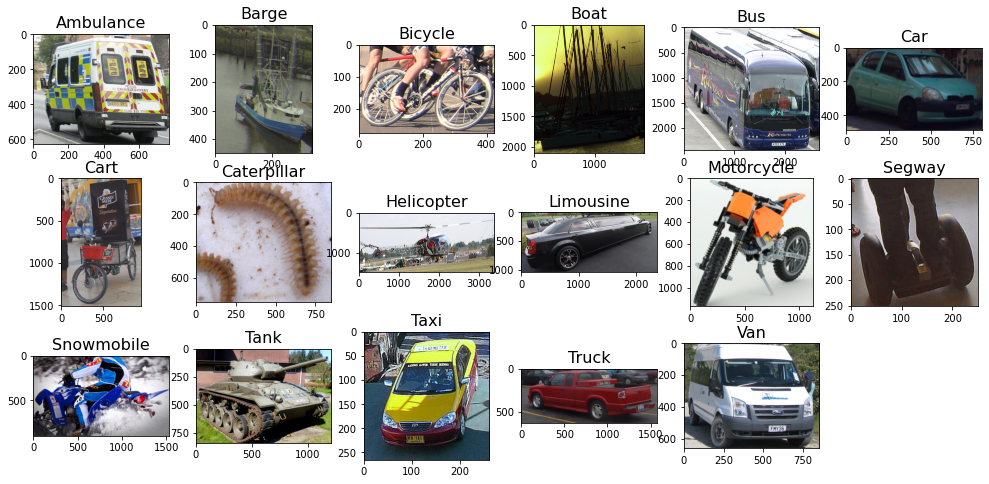

In [14]:
# check examples of image 
images=[]
for category in categories:
    cl = df_train[df_train['class'] == category]
    images.append(cl.sample(n=1)['data_path'].values[0])

plt.figure(figsize = (17, 8));
i=1
for im in images: 
    ax=plt.subplot(ceil(len(images)/6),6,i)
    img = cv2.imread(im)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(im.split('/')[-2],fontsize=16)
    i+=1

In [15]:
categories = df_train['class'].unique()

In [16]:
len(categories)

17

In [17]:
X=df_train.drop('class', axis=1)

In [18]:
# label encoder (class)
y_encoder=LabelEncoder().fit_transform(df_train['class'].values)
#y=tf.keras.utils.to_categorical(y_encoder, num_classes=len(categories))
y=y_encoder
y

array([ 0,  0,  0, ..., 16, 16, 16])

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
X_train.shape, y_train.shape

((22436, 2), (22436,))

In [21]:
X_val.shape, y_val.shape

((5609, 2), (5609,))

In [22]:
def make_dataframe_src_dst(df, path_orig, folder1, folder2):
     
    # make dataframe src-dst 
    sym=df[['data_path']].applymap(lambda x: x.replace(folder1, folder2))
    sym.columns=['dst']
    sym['src']=df['data_path'].copy()
    sym=sym[['src','dst']]
    #print(sym.head(2))
    # make directory of links for data flow from directory
    path = os.path.join('', *path_orig.split('/')[:-2],folder2)
    for new_path in categories:
        if os.path.exists(path+'/'+ new_path):
            shutil.rmtree(path+'/'+ new_path)
            os.makedirs(path+'/'+ new_path)
        else:
            os.makedirs(path+'/'+ new_path)

    # make symlink
    for index, row in sym.iterrows():
        os.symlink(os.getcwd()+'/'+row['src'], os.getcwd()+'/'+row['dst'])

In [23]:
# make dataset train - val
make_dataframe_src_dst(X_train, path_train_orig, 'trainset', 'train_folder')
make_dataframe_src_dst(X_val, path_train_orig, 'trainset', 'val_folder')

In [24]:
train_path=os.path.join('', *path_train_orig.split('/')[:-2],'train_folder/')
val_path=os.path.join('', *path_train_orig.split('/')[:-2],'val_folder/')
test_path='vehicle/test/'

In [25]:
train_path, val_path, test_path

('vehicle/train/train_folder/', 'vehicle/train/val_folder/', 'vehicle/test/')

In [26]:
# min-max image values
img.min(), img.max()

(0, 255)

## Convolutional Neural Network (CNN)

In [27]:
# epochs
epochs_val = 15

# batch_size
batch_size_val = 32

# target_size
#224
target_size_val=(128,128)

# input_shape
input_shape_val = (target_size_val[0],target_size_val[1], 3)

### Datagen

In [28]:
# Datagen and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=None)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

### Data Generator

In [29]:
# Train / Validation - Data Generator
train_generator = train_datagen.flow_from_directory(train_path,
                                 target_size=target_size_val,
                                 batch_size=batch_size_val,
                                 class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(val_path,
                                 target_size=target_size_val,
                                 batch_size=batch_size_val,
                                 class_mode = 'categorical')

# Test 
test_generator = test_datagen.flow_from_directory(test_path,
                                 target_size=target_size_val,
                                 shuffle = False,
                                 class_mode = 'categorical')

Found 22436 images belonging to 17 classes.
Found 5609 images belonging to 17 classes.
Found 7958 images belonging to 1 classes.


In [30]:
# example from DataFrame
# Train Data Generator from DataFrame
train_generator_df = train_datagen.flow_from_dataframe(dataframe=df_train, # original, without validation split
                                              x_col='data_path', 
                                              y_col='class', 
                                              target_size=target_size_val,      
                                              batch_size=batch_size_val,
                                              class_mode = 'categorical')

Found 28045 validated image filenames belonging to 17 classes.


### plot images of train_generator

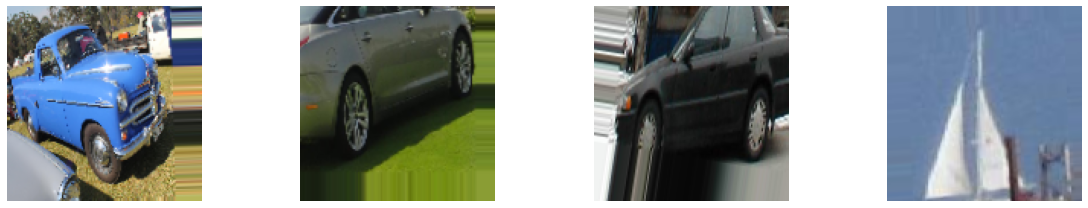

In [37]:
# plot image of train_generator
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(19,3))
for i in range(4):
    im = next(train_generator)[0][i]
    ax[i].imshow(im)
    ax[i].axis('off')
    plt.tight_layout()

### Models

In [30]:
# Custom model

model_custom = models.Sequential()
model_custom.add(Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape=input_shape_val))
model_custom.add(BatchNormalization())
model_custom.add(MaxPooling2D((2, 2)))
model_custom.add(Dropout(0.2))

model_custom.add(Conv2D(64, (3, 3), strides=1, padding = 'same', activation = 'relu'))
model_custom.add(BatchNormalization())
model_custom.add(MaxPooling2D((2, 2)))
model_custom.add(Dropout(0.2))

model_custom.add(Conv2D(128, (3, 3), strides=1, padding = 'same', activation = 'relu'))
model_custom.add(BatchNormalization())
model_custom.add(MaxPooling2D((2, 2)))
model_custom.add(Dropout(0.5))

model_custom.add(Conv2D(256, (3, 3), strides=1, padding = 'same', activation = 'relu'))
model_custom.add(BatchNormalization())
model_custom.add(MaxPooling2D((2, 2)))
model_custom.add(Dropout(0.5))


# flatten
model_custom.add(Flatten())

model_custom.add(Dense(128, activation = 'relu'))
model_custom.add(BatchNormalization())
model_custom.add(Dropout(0.5))

model_custom.add(Dense(64, activation = 'relu'))
model_custom.add(BatchNormalization())

model_custom.add(Dense(17, activation = 'softmax'))

# name
model_custom._name = "model_custom"
# summary
#model_custom.summary()

2022-04-27 20:13:41.891397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 20:13:41.935359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 20:13:41.935856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 20:13:41.937494: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [31]:
# Model inception_v3

model_inception_v3 = tf.keras.applications.InceptionV3(
    weights='imagenet', include_top = False, input_shape = input_shape_val)

for layer in model_inception_v3.layers:
    layer.trainable=False
    
x = model_inception_v3.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# output layer
output_inception_v3 = tf.keras.layers.Dense(17, activation = 'softmax')(x)

# model
model_inception_v3 = tf.keras.Model(inputs=model_inception_v3.input, outputs=output_inception_v3)

# name
model_inception_v3._name = "model_inception_v3"
# summary
#model_inception_v3.summary()

In [32]:
# Model EfficientNet

model_EfficientNet = tf.keras.applications.EfficientNetB7(
    weights='imagenet', include_top = False, input_shape = input_shape_val)

for layer in model_EfficientNet.layers:
    layer.trainable=False
    
x = model_EfficientNet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# output layer
output_EfficientNet = tf.keras.layers.Dense(17, activation = 'softmax')(x)

# model
model_EfficientNet = tf.keras.Model(inputs=model_EfficientNet.input, outputs=output_EfficientNet)

# name
model_EfficientNet._name = "model_EfficientNet"
# summary
#model_EfficientNet.summary()

### class_weight - optimizer - overfitting

In [33]:
# class_weight - Unbalanced Data

counter = Counter(train_generator.classes)    
class_weights = dict(zip(list(counter.keys()),
                class_weight.compute_class_weight('balanced',list(counter.keys()),train_generator.classes)))
class_weights = None

In [34]:
# Define optimizer
optimizer = optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [35]:
# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=4) 

### Compile and Fit models function

In [36]:
if os.path.exists('models/'):
    pass
else:
    os.makedirs('models/')

In [37]:
# run models fuction

filepath=os.getcwd()+'/models/'
def run_model(model):
    
    # save best model (callback)
    modelCheckpoint = ModelCheckpoint(filepath+'{}.h5'.format(model.name), save_best_only = True)
    
    # Compile the model
    model.compile(optimizer = optimizer , loss = 'categorical_crossentropy', metrics=["accuracy"])
    
    # Fit the model
    history = model.fit_generator(generator=train_generator,
                              epochs = epochs_val,
                              steps_per_epoch=X_train.shape[0] // (batch_size_val*3),
                              callbacks=[early_stopping, rlr, modelCheckpoint],
                              class_weight=class_weights,
                              validation_data = validation_generator)
    
    print(history.history.keys())
    
    return model, history

### Plot models function

In [38]:
def plot_model_output(history, name='model'):
    
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy_values = history_dict['accuracy']
    val_accuracy_values = history_dict['val_accuracy']
    
    fig = plt.figure(figsize=(19,3))
    
    plt.subplot(1, 2, 1)
    plt.suptitle(name, fontsize=18)
    plt.title('loss')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,loss_values, '--',label='loss')
    plt.plot(epoch,val_loss_values, '--',label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.suptitle(name, fontsize=18)
    plt.title('accuracy')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,accuracy_values, '--',label='accuracy')
    plt.plot(epoch,val_accuracy_values, '--',label='val_accuracy')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

### Run and plot model

In [39]:
max_accuracy=[]

In [40]:
# Run model 
tf.keras.backend.clear_session()
custom_model, history_custom = run_model(model_custom)
max_accuracy.append(('{}.h5'.format(custom_model.name),np.max(history_custom.history['accuracy'])))

Epoch 1/15


2022-04-27 20:14:03.794231: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


233/233 [==============================] - 430s 2s/step - loss: 2.5039 - accuracy: 0.2931 - val_loss: 3.2165 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 2/15
233/233 [==============================] - 273s 1s/step - loss: 1.9384 - accuracy: 0.3908 - val_loss: 1.8723 - val_accuracy: 0.3616 - lr: 0.0010
Epoch 3/15
233/233 [==============================] - 244s 1s/step - loss: 1.7703 - accuracy: 0.4202 - val_loss: 1.6323 - val_accuracy: 0.4602 - lr: 0.0010
Epoch 4/15
233/233 [==============================] - 222s 951ms/step - loss: 1.6714 - accuracy: 0.4528 - val_loss: 1.5387 - val_accuracy: 0.4739 - lr: 0.0010
Epoch 5/15
233/233 [==============================] - 235s 1s/step - loss: 1.6363 - accuracy: 0.4631 - val_loss: 1.4503 - val_accuracy: 0.5388 - lr: 0.0010
Epoch 6/15
233/233 [==============================] - 281s 1s/step - loss: 1.5765 - accuracy: 0.4906 - val_loss: 1.5309 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 7/15
233/233 [==============================] - 222s 955ms/step - 

In [41]:
# Run model
tf.keras.backend.clear_session()
inception_v3_model, history_inception_v3 = run_model(model_inception_v3)
max_accuracy.append(('{}.h5'.format(inception_v3_model.name),np.max(history_inception_v3.history['accuracy'])))

Epoch 1/15


2022-04-27 21:07:14.402650: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1007.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-27 21:07:14.421076: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-27 21:07:14.440011: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-27 21:07:14.569147: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Al

  2/233 [..............................] - ETA: 23s - loss: 3.3771 - accuracy: 0.1250  

2022-04-27 21:07:14.608252: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.85GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-27 21:07:14.655377: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


233/233 [==============================] - ETA: 0s - loss: 1.2965 - accuracy: 0.6481

2022-04-27 21:09:47.795847: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 942.88MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-27 21:09:47.811507: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-27 21:09:47.827768: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


233/233 [==============================] - 163s 668ms/step - loss: 1.2965 - accuracy: 0.6481 - val_loss: 0.8722 - val_accuracy: 0.7511 - lr: 1.0000e-04
Epoch 2/15
233/233 [==============================] - 141s 606ms/step - loss: 1.0707 - accuracy: 0.6923 - val_loss: 0.7528 - val_accuracy: 0.7704 - lr: 1.0000e-04
Epoch 3/15
233/233 [==============================] - 146s 628ms/step - loss: 0.9677 - accuracy: 0.7175 - val_loss: 0.7219 - val_accuracy: 0.7775 - lr: 1.0000e-04
Epoch 4/15
233/233 [==============================] - 148s 635ms/step - loss: 0.9516 - accuracy: 0.7186 - val_loss: 0.6913 - val_accuracy: 0.7821 - lr: 1.0000e-04
Epoch 5/15
233/233 [==============================] - 146s 628ms/step - loss: 0.9274 - accuracy: 0.7182 - val_loss: 0.6688 - val_accuracy: 0.7864 - lr: 1.0000e-04
Epoch 6/15
233/233 [==============================] - 145s 623ms/step - loss: 0.9018 - accuracy: 0.7299 - val_loss: 0.6586 - val_accuracy: 0.7932 - lr: 1.0000e-04
Epoch 7/15
233/233 [=============

In [42]:
# Run model
tf.keras.backend.clear_session()
EfficientNet_model, history_EfficientNet = run_model(model_EfficientNet)
max_accuracy.append(('{}.h5'.format(EfficientNet_model.name),np.max(history_EfficientNet.history['accuracy'])))

Epoch 1/15
233/233 [==============================] - 282s 1s/step - loss: 2.8730 - accuracy: 0.1532 - val_loss: 2.5950 - val_accuracy: 0.2418 - lr: 1.0000e-04
Epoch 2/15
233/233 [==============================] - 275s 1s/step - loss: 2.6085 - accuracy: 0.2182 - val_loss: 2.3086 - val_accuracy: 0.2418 - lr: 1.0000e-04
Epoch 3/15
233/233 [==============================] - 273s 1s/step - loss: 2.4529 - accuracy: 0.2550 - val_loss: 2.3712 - val_accuracy: 0.2418 - lr: 1.0000e-04
Epoch 4/15
233/233 [==============================] - 268s 1s/step - loss: 2.3626 - accuracy: 0.2609 - val_loss: 2.3397 - val_accuracy: 0.2418 - lr: 1.0000e-04
Epoch 5/15
233/233 [==============================] - 270s 1s/step - loss: 2.3148 - accuracy: 0.2676 - val_loss: 2.1398 - val_accuracy: 0.2418 - lr: 1.0000e-04
Epoch 6/15
233/233 [==============================] - 276s 1s/step - loss: 2.2745 - accuracy: 0.2719 - val_loss: 2.1117 - val_accuracy: 0.3100 - lr: 1.0000e-04
Epoch 7/15
233/233 [====================

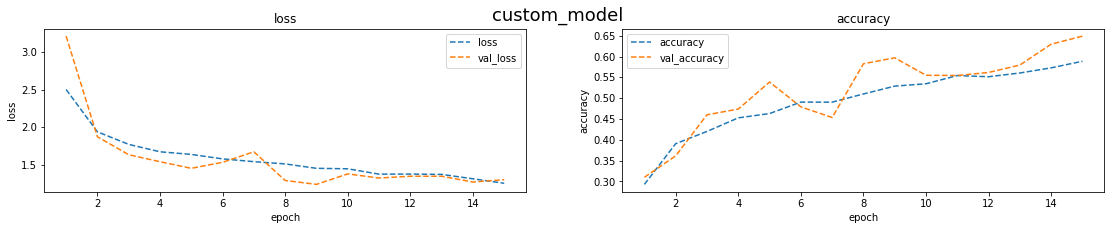

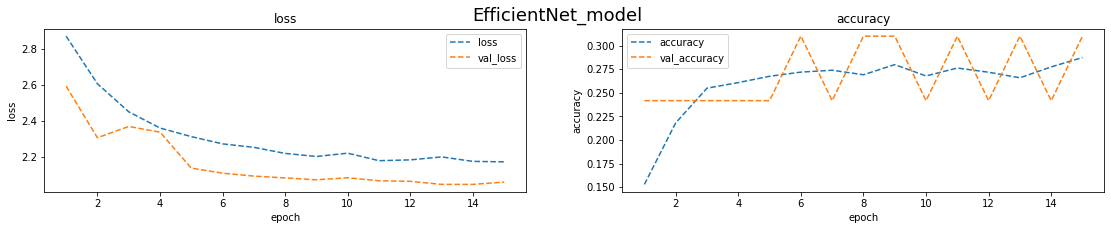

In [43]:
# plot model ouputs
plot_model_output(history_custom, 'custom_model')
plot_model_output(history_EfficientNet, 'EfficientNet_model')

In [44]:
# get best model
best_model_df=pd.DataFrame(max_accuracy, columns=['model','accuracy'])
best_model_df.sort_values(by=['accuracy'], ascending=False, inplace=True)
best_model_df

,model,accuracy
1,model_inception_v3.h5,0.749732
0,model_custom.h5,0.588653
2,model_EfficientNet.h5,0.287426


In [45]:
best_model=best_model_df.iloc[0]['model']

In [46]:
# load best model
load_model = tf.keras.models.load_model('models/'+best_model, compile = False)
load_model

In [47]:
#resnet_model.evaluate(test_generator)
#load_model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])
#load_model.evaluate(test_generator)

In [54]:
filenames = test_generator.filenames
filenames[0:3]

['testset/000000.jpg', 'testset/000001.jpg', 'testset/000002.jpg']

In [48]:
predictions = load_model.predict(test_generator)

In [49]:
predictions[0:3]

array([[2.6391682e-04, 2.3812982e-03, 3.2845090e-04, 9.6114433e-01,
        3.0651843e-04, 7.9665278e-06, 9.2532707e-04, 1.1385252e-03,
        2.4870474e-02, 6.6140422e-04, 2.1318607e-04, 9.1269735e-04,
        2.1615529e-03, 3.9304560e-03, 3.5873556e-04, 7.5212847e-05,
        3.1993166e-04],
       [8.1909578e-03, 1.8160254e-03, 9.9110687e-03, 4.5655612e-04,
        6.1499536e-02, 5.8124566e-01, 5.8167204e-03, 4.6194843e-03,
        2.2184576e-03, 8.4863212e-03, 2.8558744e-02, 2.5639900e-03,
        2.0034201e-03, 9.0968423e-04, 9.2153102e-03, 6.1866634e-02,
        2.1062142e-01],
       [2.1120429e-03, 2.4119439e-04, 1.8730116e-05, 4.3672489e-06,
        5.6862738e-03, 5.2520299e-01, 8.4225746e-04, 6.7667128e-04,
        5.3124288e-03, 8.4457156e-04, 3.8267525e-03, 1.6991481e-03,
        1.3762002e-03, 2.8566080e-03, 3.3118413e-04, 4.4454640e-01,
        4.4222218e-03]], dtype=float32)

In [57]:
np.argmax(predict[1])

5

In [61]:
pred_class=[]
for i in range(len(predict)):
    pred_class.append(np.argmax(predict[i]))

In [64]:
pred_class[0:3]

[3, 5, 5]

In [63]:
train_generator_dict={y: x for x, y in train_generator.class_indices.items()}
train_generator_dict

{0: 'Ambulance',
 1: 'Barge',
 2: 'Bicycle',
 3: 'Boat',
 4: 'Bus',
 5: 'Car',
 6: 'Cart',
 7: 'Caterpillar',
 8: 'Helicopter',
 9: 'Limousine',
 10: 'Motorcycle',
 11: 'Segway',
 12: 'Snowmobile',
 13: 'Tank',
 14: 'Taxi',
 15: 'Truck',
 16: 'Van'}